# Comprehensive Clustering Methods Comparison
This notebook compares K-means, GMM, Agglomerative, and OPTICS clustering on PCA-transformed EEG data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import clustering functions
from functions.k_means_clustering import kmeans_multiple_runs, select_optimal_k
from functions.gmm_clustering import gmm_clustering, select_optimal_n_gmm
from functions.agglomerative_clustering import agglomerative_clustering, select_optimal_n_agglomerative
from functions.optics_clustering import optics_clustering, tune_optics_min_samples

# Import preprocessing
from functions.feature_preprocessing import load_pca_data

# Import metrics
from metrics.internal_metrics import (
    compute_silhouette_score,
    compute_davies_bouldin_score,
    compute_calinski_harabasz_score
)

In [2]:
pca_data, pca_features, loadings = load_pca_data()
print(f"Data shape: {pca_features.shape}")
print(f"Number of subjects: {pca_features.shape[0]}")
print(f"Number of PCA components: {pca_features.shape[1]}")

Data shape: (600, 16)
Number of subjects: 600
Number of PCA components: 16


In [3]:

k_range = list(range(2, 11))

## 1. K-Means Clustering

In [4]:
print("Finding optimal k for K-means...")
optimal_k_kmeans, kmeans_results = select_optimal_k(
    pca_features, 
    k_range=k_range, 
    metric='elbow',
    n_runs=10,
    random_state=42
)
print(f"Optimal k (K-means): {optimal_k_kmeans}")

# Get best result
kmeans_best = kmeans_results[optimal_k_kmeans]
kmeans_labels = kmeans_best['assignments']

# Compute metrics
kmeans_metrics = {
    'silhouette': compute_silhouette_score(pca_features, kmeans_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, kmeans_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, kmeans_labels),
}

print(f"\nK-means Metrics (k={optimal_k_kmeans}):")
print(f"  Silhouette Score: {kmeans_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_metrics['calinski_harabasz']:.2f}")

Finding optimal k for K-means...
Optimal k (K-means): 6

K-means Metrics (k=6):
  Silhouette Score: 0.1144
  Davies-Bouldin Index: 2.0100
  Calinski-Harabasz Score: 68.45


## 2. Gaussian Mixture Model (GMM)

In [5]:
print("Finding optimal number of components for GMM...")
optimal_k_gmm, gmm_results = select_optimal_n_gmm(
    pca_features,
    n_range=k_range,
    metric='bic',
    covariance_type='full',
    random_state=42,
    verbose=False
)
print(f"Optimal k (GMM): {optimal_k_gmm}")

# Get best result
gmm_best = gmm_results[optimal_k_gmm]
gmm_labels = gmm_best['labels']

# Compute metrics
gmm_metrics = {
    'silhouette': compute_silhouette_score(pca_features, gmm_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, gmm_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, gmm_labels),
    'bic': gmm_best['bic'],
    'aic': gmm_best['aic']
}

print(f"\nGMM Metrics (k={optimal_k_gmm}):")
print(f"  Silhouette Score: {gmm_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {gmm_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {gmm_metrics['calinski_harabasz']:.2f}")
print(f"  BIC: {gmm_metrics['bic']:.2f}")
print(f"  AIC: {gmm_metrics['aic']:.2f}")

Finding optimal number of components for GMM...
Optimal k (GMM): 3

GMM Metrics (k=3):
  Silhouette Score: 0.1469
  Davies-Bouldin Index: 2.2201
  Calinski-Harabasz Score: 66.29
  BIC: 43625.31
  AIC: 41611.51


## 3. Agglomerative Clustering

In [6]:
print("Finding optimal k for Agglomerative clustering...")
optimal_k_agg, agg_results = select_optimal_n_agglomerative(
    pca_features,
    n_range=k_range,
    metric='euclidean',
    linkage_method='ward',
    selection_metric='silhouette',
    verbose=False
)
print(f"Optimal k (Agglomerative): {optimal_k_agg}")

# Get best result
agg_best = agg_results[optimal_k_agg]
agg_labels = agg_best['labels']

# Compute metrics
agg_metrics = {
    'silhouette': compute_silhouette_score(pca_features, agg_labels),
    'davies_bouldin': compute_davies_bouldin_score(pca_features, agg_labels),
    'calinski_harabasz': compute_calinski_harabasz_score(pca_features, agg_labels),
}

print(f"\nAgglomerative Metrics (k={optimal_k_agg}):")
print(f"  Silhouette Score: {agg_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {agg_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Score: {agg_metrics['calinski_harabasz']:.2f}")

Finding optimal k for Agglomerative clustering...
Optimal k (Agglomerative): 3

Agglomerative Metrics (k=3):
  Silhouette Score: 0.1564
  Davies-Bouldin Index: 2.1861
  Calinski-Harabasz Score: 78.32


## 4. OPTICS Clustering

In [8]:
min_samples_range = [5, 10, 15, 20, 25]
optimal_min_samples, optics_results = tune_optics_min_samples(
    pca_features,
    min_samples_range=min_samples_range,
    metric='euclidean',
    cluster_method='xi',
    xi=0.01,
    verbose=False
)
print(f"Optimal min_samples (OPTICS): {optimal_min_samples}")

# Get best result
optics_best = optics_results[optimal_min_samples]
optics_labels = optics_best['labels']
optics_n_clusters = optics_best['n_clusters']

print(f"OPTICS found {optics_n_clusters} clusters")

# Compute metrics (excluding noise points)
if optics_n_clusters > 1:
    non_noise_mask = optics_labels != -1
    n_noise = np.sum(~non_noise_mask)
    print(f"Number of noise points: {n_noise}")
    
    if np.sum(non_noise_mask) > 0:
        filtered_data = pca_features[non_noise_mask]
        filtered_labels = optics_labels[non_noise_mask]
        
        optics_metrics = {
            'silhouette': compute_silhouette_score(filtered_data, filtered_labels),
            'davies_bouldin': compute_davies_bouldin_score(filtered_data, filtered_labels),
            'calinski_harabasz': compute_calinski_harabasz_score(filtered_data, filtered_labels),
            'n_noise': n_noise
        }
        
        print(f"\nOPTICS Metrics (k={optics_n_clusters}, excluding noise):")
        print(f"  Silhouette Score: {optics_metrics['silhouette']:.4f}")
        print(f"  Davies-Bouldin Index: {optics_metrics['davies_bouldin']:.4f}")
        print(f"  Calinski-Harabasz Score: {optics_metrics['calinski_harabasz']:.2f}")
    else:
        print("All points classified as noise!")
        optics_metrics = {'silhouette': -1, 'davies_bouldin': np.inf, 'calinski_harabasz': 0, 'n_noise': n_noise}
else:
    print("OPTICS did not find valid clusters")
    optics_metrics = {'silhouette': -1, 'davies_bouldin': np.inf, 'calinski_harabasz': 0, 'n_noise': len(optics_labels)}

Optimal min_samples (OPTICS): 10
OPTICS found 3 clusters
Number of noise points: 567

OPTICS Metrics (k=3, excluding noise):
  Silhouette Score: 0.2659
  Davies-Bouldin Index: 1.3509
  Calinski-Harabasz Score: 20.78


## Summary for viasualization

In [9]:
# Create summary dataframe
summary_data = {
    'Algorithm': ['K-means', 'GMM', 'Agglomerative', 'OPTICS'],
    'Optimal k': [optimal_k_kmeans, optimal_k_gmm, optimal_k_agg, optics_n_clusters],
    'Silhouette': [
        kmeans_metrics['silhouette'],
        gmm_metrics['silhouette'],
        agg_metrics['silhouette'],
        optics_metrics['silhouette']
    ],
    'Davies-Bouldin': [
        kmeans_metrics['davies_bouldin'],
        gmm_metrics['davies_bouldin'],
        agg_metrics['davies_bouldin'],
        optics_metrics['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        kmeans_metrics['calinski_harabasz'],
        gmm_metrics['calinski_harabasz'],
        agg_metrics['calinski_harabasz'],
        optics_metrics['calinski_harabasz']
    ]
}

summary_df = pd.DataFrame(summary_data)

## Visualization

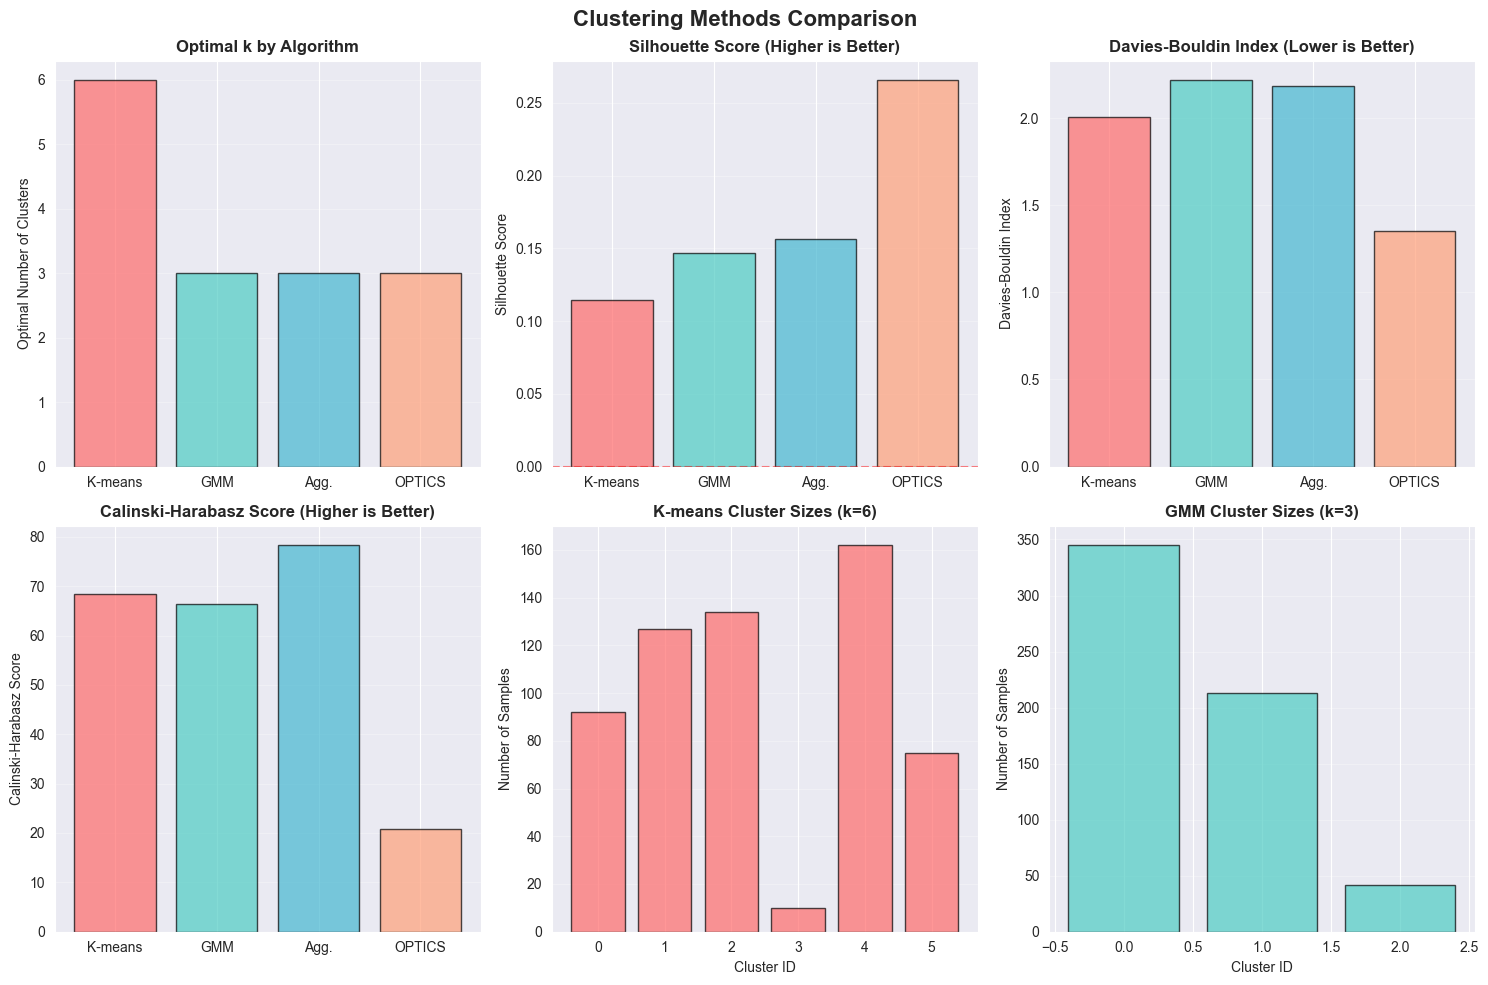


Analysis complete!


In [10]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Clustering Methods Comparison', fontsize=16, fontweight='bold')

algorithms = ['K-means', 'GMM', 'Agg.', 'OPTICS']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# Plot 1: Optimal k comparison
ax1 = axes[0, 0]
optimal_ks = [optimal_k_kmeans, optimal_k_gmm, optimal_k_agg, optics_n_clusters]
ax1.bar(algorithms, optimal_ks, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Optimal Number of Clusters', fontsize=10)
ax1.set_title('Optimal k by Algorithm', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Silhouette Score comparison
ax2 = axes[0, 1]
silhouette_scores = summary_df['Silhouette'].tolist()
ax2.bar(algorithms, silhouette_scores, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Silhouette Score', fontsize=10)
ax2.set_title('Silhouette Score (Higher is Better)', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Davies-Bouldin Index comparison
ax3 = axes[0, 2]
db_scores = summary_df['Davies-Bouldin'].tolist()
ax3.bar(algorithms, db_scores, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=10)
ax3.set_title('Davies-Bouldin Index (Lower is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Calinski-Harabasz Score comparison
ax4 = axes[1, 0]
ch_scores = summary_df['Calinski-Harabasz'].tolist()
ax4.bar(algorithms, ch_scores, color=colors, alpha=0.7, edgecolor='black')
ax4.set_ylabel('Calinski-Harabasz Score', fontsize=10)
ax4.set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Plot 5: Cluster size distribution for K-means
ax5 = axes[1, 1]
unique_labels, counts = np.unique(kmeans_labels, return_counts=True)
ax5.bar(unique_labels, counts, color='#FF6B6B', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Cluster ID', fontsize=10)
ax5.set_ylabel('Number of Samples', fontsize=10)
ax5.set_title(f'K-means Cluster Sizes (k={optimal_k_kmeans})', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)

# Plot 6: Cluster size distribution for GMM
ax6 = axes[1, 2]
unique_labels, counts = np.unique(gmm_labels, return_counts=True)
ax6.bar(unique_labels, counts, color='#4ECDC4', alpha=0.7, edgecolor='black')
ax6.set_xlabel('Cluster ID', fontsize=10)
ax6.set_ylabel('Number of Samples', fontsize=10)
ax6.set_title(f'GMM Cluster Sizes (k={optimal_k_gmm})', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")